# <span style="color:blue">EEG Alcoholism Prerdisposition</span>
Data files and a description of the data are available on kaggle at [this link](https://www.kaggle.com/datasets/nnair25/Alcoholics).

<img src="images/EEG_test.png" width="600" height="100">

<span style="color:gray">Courtesy of Fotografixx/Getty Images</span>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import os
import random

2023-06-20 11:06:17.682229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 11:06:17.682277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## <span style="color:blue">Training Data</span>

In [2]:
work_dir = os.getcwd() + '/' # save the path to the current directory.

In [3]:
filenames = [] # name of the csv files in the training set.
df_train_orig = pd.DataFrame(columns=[]) # All the csv files will concatenate to this file to.
for (root, dirs, files) in os.walk(work_dir+"data/SMNI_CMI_TRAIN/"):
    for name in files:
        filenames.append(name)
        file = pd.read_csv(root+name)
        df_train_orig = pd.concat([df_train_orig, file])

In [4]:
df_train_orig.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,11,FP1,0,2.787,a,S2 match,0,co2a0000365,0.000000
1,6,11,FP1,1,1.322,a,S2 match,0,co2a0000365,0.003906
2,7,11,FP1,2,1.811,a,S2 match,0,co2a0000365,0.007812
3,8,11,FP1,3,4.252,a,S2 match,0,co2a0000365,0.011719
4,9,11,FP1,4,6.205,a,S2 match,0,co2a0000365,0.015625


According to the guidlines issued by the American Clinical Neurophysiology Society,
the current standard electrode position on a human head assumes the following pattern:
<img src="images/EEG_electrode_pattern_ACNS.png" width="350" height="350">

In this analysis, we assume that both the presented order of the EEG electrodes as well as their letter labeling follow a similar standard. Although there are three electrodes 'nd', 'X', and 'Y' that are not found on this map, we decide to keep them since they might share similar positions as their counterparts yet coming with different name labels.

In [5]:
# drop columns with no useful information,
# 'sample num' shows equivalent information as 'time' column: sample num = (time * frequency)^{-1}
# 'channel' number is equivalent to 'sensor position'.
df_train = df_train_orig.drop(['Unnamed: 0', 'sample num', 'channel'], axis=1)

# move the target feature "subject identifier" to the last column.
df_train.insert((df_train.shape[1]-1), 'subject identifier', df_train.pop('subject identifier'))
df_train.head()

,trial number,sensor position,sensor value,matching condition,name,time,subject identifier
0,11,FP1,2.787,S2 match,co2a0000365,0.000000,a
1,11,FP1,1.322,S2 match,co2a0000365,0.003906,a
2,11,FP1,1.811,S2 match,co2a0000365,0.007812,a
3,11,FP1,4.252,S2 match,co2a0000365,0.011719,a
4,11,FP1,6.205,S2 match,co2a0000365,0.015625,a


## <span style="color:blue">Sample Data Analysis</span>

In [6]:
# some definitions here:
feature_names = df_train.columns.values.tolist()
channels = np.unique(df_train['sensor position']).tolist()
stimuli = np.unique(df_train['matching condition']).tolist()
alcoholic_id = np.unique(df_train['name'].loc[df_train['subject identifier'] == 'a']).tolist()
control_id = np.unique(df_train['name'].loc[df_train['subject identifier'] == 'c']).tolist()

### 3D scatter plots

In [29]:
# function to plot 3D surface given stimulus type ('matching condition') as a free parameter
def scatter_plot_channels(df, stimulus, alcoholic_id=[], control_id=[], random_seed = 42):

    '''
    df: data frame containing the data for both alcoholic and control groups
    stimulus: the type of stimulus, i.e. 'matching condition'
    alcoholic_id: a list of id 'names' associated with alcoholic group
    control_id: a list of id 'names' associated with control group
    '''
    
    random.seed(random_seed)
    selected_features = ['sensor position', 'sensor value', 'time']
    
    # pick a random id for both groups
    rand_id_a = random.choice(alcoholic_id)
    rand_id_c = random.choice(control_id)
    
    # create sample random data files based on id's and stimulus type from the alcoholic group.
    rand_df_a = df.loc[(df['name'] == rand_id_a) & (df['matching condition'] == stimulus)]
    rand_df_a = rand_df_a[selected_features]

    # plotly's scatter plot does not directly support categorical axes. So, we create a category-numeric set instead.
    category_dic = {category: i for i, category in enumerate(sorted(set(rand_df_a['sensor position'])))}
    rand_df_a['sensorpos_numeric'] = [category_dic[category] for category in rand_df_a['sensor position']]

    # Create a 3D scatter plot
    fig = px.scatter_3d(rand_df_a, x='time', y='sensorpos_numeric', z='sensor value', color='sensor value', color_continuous_scale='Viridis')

    # Customize the plot if needed
    fig.update_traces(marker=dict(size=1))
    fig.update_layout(
        width = 900,
        height = 800,
        scene=dict(
            xaxis=dict(title='time'),
            yaxis=dict(
                tickmode='array',
                tickvals=list(category_dic.values()),
                ticktext=list(category_dic.keys()),
                title = 'sensor position'
            ),
            zaxis=dict(title='sensor value')
        ),
        title='sample alcoholic group scatter plot for id # '+rand_id_a+' and '+stimulus+' stimulus'
    )

    # Display the interactive plot
    fig.show()
    # fig.write_image('plot1.png')

    
    # create a similar plot for the control group.
    rand_df_c = df.loc[(df['name'] == rand_id_c) & (df['matching condition'] == stimulus)]
    rand_df_c = rand_df_c[selected_features]

    category_dic = {category: i for i, category in enumerate(sorted(set(rand_df_c['sensor position'])))}
    rand_df_c['sensorpos_numeric'] = [category_dic[category] for category in rand_df_c['sensor position']]

    fig = px.scatter_3d(rand_df_c, x='time', y='sensorpos_numeric', z='sensor value', color='sensor value', color_continuous_scale='Viridis')
    fig.update_traces(marker=dict(size=1))
    fig.update_layout(
        width = 900,
        height = 800,
        scene=dict(
            xaxis=dict(title='time'),
            yaxis=dict(
                tickmode='array',
                tickvals=list(category_dic.values()),
                ticktext=list(category_dic.keys()),
                title = 'sensor position'
            ),
            zaxis=dict(title='sensor value')
        ),
        title='sample control group scatter plot for id # '+rand_id_c+' and '+stimulus+' stimulus'
    )
    
    fig.show()
    # fig.write_image('plot2.png')
    print(f'alcoholic sample data size: {rand_df_a.shape}, control sample data size: {rand_df_c.shape}')

In [ ]:
scatter_plot_channels(df = df_train, alcoholic_id = alcoholic_id, control_id = control_id, stimulus = stimuli[0], random_seed = 28)

<img src="images/group_a_stimulus_S1.png" width="700" height="700">
<img src="images/group_c_stimulus_S1.png" width="700" height="700">

In [ ]:
scatter_plot_channels(df = df_train, alcoholic_id = alcoholic_id, control_id = control_id, stimulus = stimuli[1], random_seed = 17)

<img src="images/group_a_stimulus_S2match.png" width="700" height="700">
<img src="images/group_c_stimulus_S2match.png" width="700" height="700">

In [ ]:
scatter_plot_channels(df = df_train, alcoholic_id = alcoholic_id, control_id = control_id, stimulus = stimuli[2], random_seed = 65)

<img src="images/group_a_stimulus_S2nonmatch.png" width="700" height="700">
<img src="images/group_c_stimulus_S2nonmatch.png" width="700" height="700">

The above analysis shows that senors that are positionally juxtaposed, tend to show correlated signals (assuming that the letter labeling order of the electrodes in the data set follows a standard positional order).

Next, we check how the mean and standard deviation of the EEG signals vary accross channels and stimuli.

### Statistical properties of signals

In [7]:
# Let's group the channels by their topical domains to better
# visualize some statistical properties of the signals.
from itertools import groupby
sorted_channels = sorted(channels)
ch_domains = [tuple(ch) for key, ch in groupby(sorted_channels, lambda x: x[0])]
ch_domains = [item for item in ch_domains if len(item) > 1] # keep only the domains with >1 channels

In [21]:
# function to bar charts given the type of statistical analysis (being mean or stdev) as a free parameter
def domains_bar_chart(df, stats = '', domains=[], stimuli=[], alcoholic_id=[], control_id=[], random_seed = 42):

    '''
    df: data frame containing the data for both alcoholic and control groups
    stats: a string specifying the type of statistical analysis; could be either "mean" or "stdev"
    domains: a list of tuples containing domains of channels
    stimuli: a list of stimuli types
    alcoholic_id: a list of id 'names' associated with alcoholic group
    control_id: a list of id 'names' associated with control group
    '''
    
    random.seed(random_seed)
    selected_features = ['sensor position', 'sensor value', 'matching condition', 'subject identifier']
    
    # pick a random id for both groups
    rand_id_a = random.choice(alcoholic_id)
    rand_id_c = random.choice(control_id)

    # create sample random data files based on an individual's id
    rand_df_a = df.loc[(df['name'] == rand_id_a)]
    rand_df_c = df.loc[(df['name'] == rand_id_c)]
    rand_df_a = rand_df_a[selected_features]
    rand_df_c = rand_df_c[selected_features]
    
    n_domain = len(domains)
    n_stimulus = len(stimuli)
    
    print(f'stimuli: {stimuli}')
    for index, domain in enumerate(domains):
        print(f'domain {index+1}: {domain}')
    
    fig, ax = plt.subplots(n_stimulus, n_domain, figsize=(22, 20))
    
    for i in range(n_stimulus):
        for j in range(n_domain):
            filtered_df = rand_df_a.loc[(rand_df_a['matching condition'] == stimuli[i]) & \
                                   (rand_df_a['sensor position'].isin(ch_domains[j]))]
            filtered_df = pd.concat([filtered_df, rand_df_c.loc[(rand_df_c['matching condition'] == stimuli[i]) & \
                                                           (rand_df_c['sensor position'].isin(ch_domains[j]))]])
            if (stats == 'mean'):
                grouped = filtered_df.groupby(['subject identifier', 'sensor position'])['sensor value'].mean().unstack()
                grouped.plot(kind='bar', stacked=True, width = .1, ax=ax[i,j], cmap='viridis')
            elif (stats == 'stdev'):
                grouped = filtered_df.groupby(['subject identifier', 'sensor position'])['sensor value'].std().unstack()
                grouped.plot(kind='bar', stacked=True, width = .1, ax=ax[i,j], cmap='plasma')
            if (i == n_stimulus -1):
                ax[i,j].set_xlabel('subject identifier', fontsize=14)
            else:
                ax[i,j].set_xlabel('')
            if (j == 0):
                ax[i,j].set_ylabel(f'{stats} signal value', fontsize=14)
            else:
                ax[i,j].set_ylabel('')
            ax[i,j].set_title(f"{stimuli[i]}, domain {j+1}", fontsize=12)
            ax[i,j].legend(fontsize='small')
            

    fig.suptitle(stats+" values of signals separated by domain and stimulus type", fontsize=22)
    fig.show()

stimuli: ['S1 obj', 'S2 match', 'S2 nomatch,']
domain 1: ('AF1', 'AF2', 'AF7', 'AF8', 'AFZ')
domain 2: ('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ')
domain 3: ('F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ')
domain 4: ('O1', 'O2', 'OZ')
domain 5: ('P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1', 'PO2', 'PO7', 'PO8', 'POZ', 'PZ')
domain 6: ('T7', 'T8', 'TP7', 'TP8')


/tmp/ipykernel_4334/3186890364.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


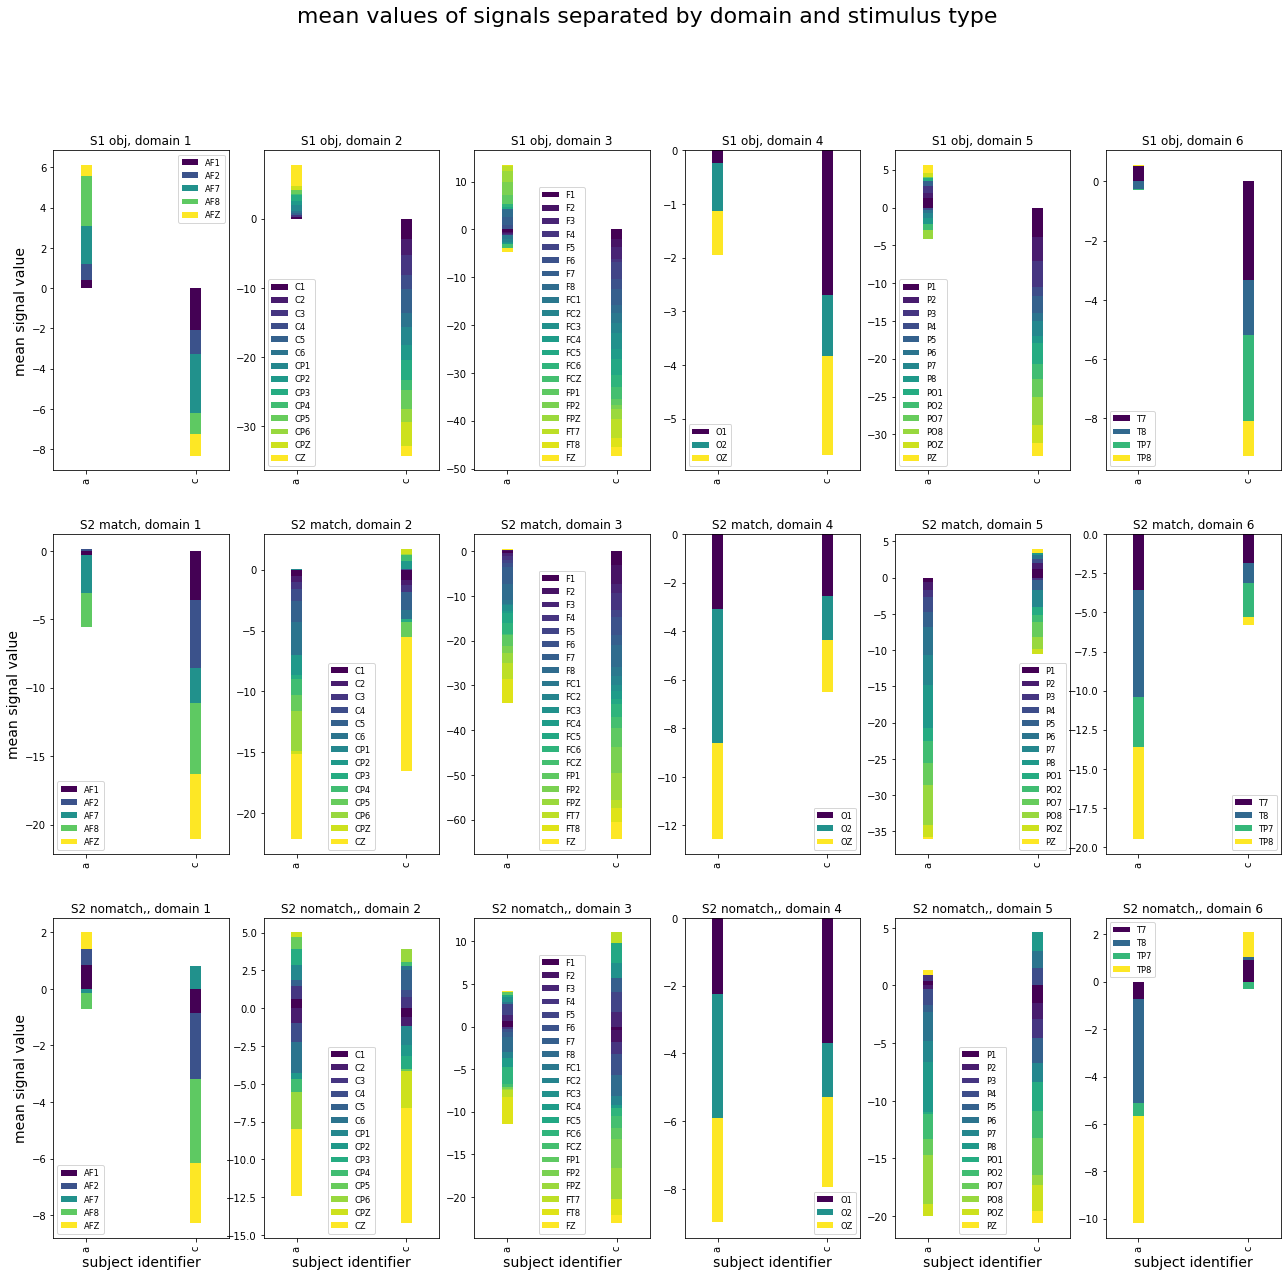

In [22]:
domains_bar_chart(df=df_train, stats = 'mean', domains=ch_domains, stimuli=stimuli, alcoholic_id=alcoholic_id, control_id=control_id, random_seed = 23)

stimuli: ['S1 obj', 'S2 match', 'S2 nomatch,']
domain 1: ('AF1', 'AF2', 'AF7', 'AF8', 'AFZ')
domain 2: ('C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ')
domain 3: ('F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ')
domain 4: ('O1', 'O2', 'OZ')
domain 5: ('P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1', 'PO2', 'PO7', 'PO8', 'POZ', 'PZ')
domain 6: ('T7', 'T8', 'TP7', 'TP8')


/tmp/ipykernel_4334/3186890364.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


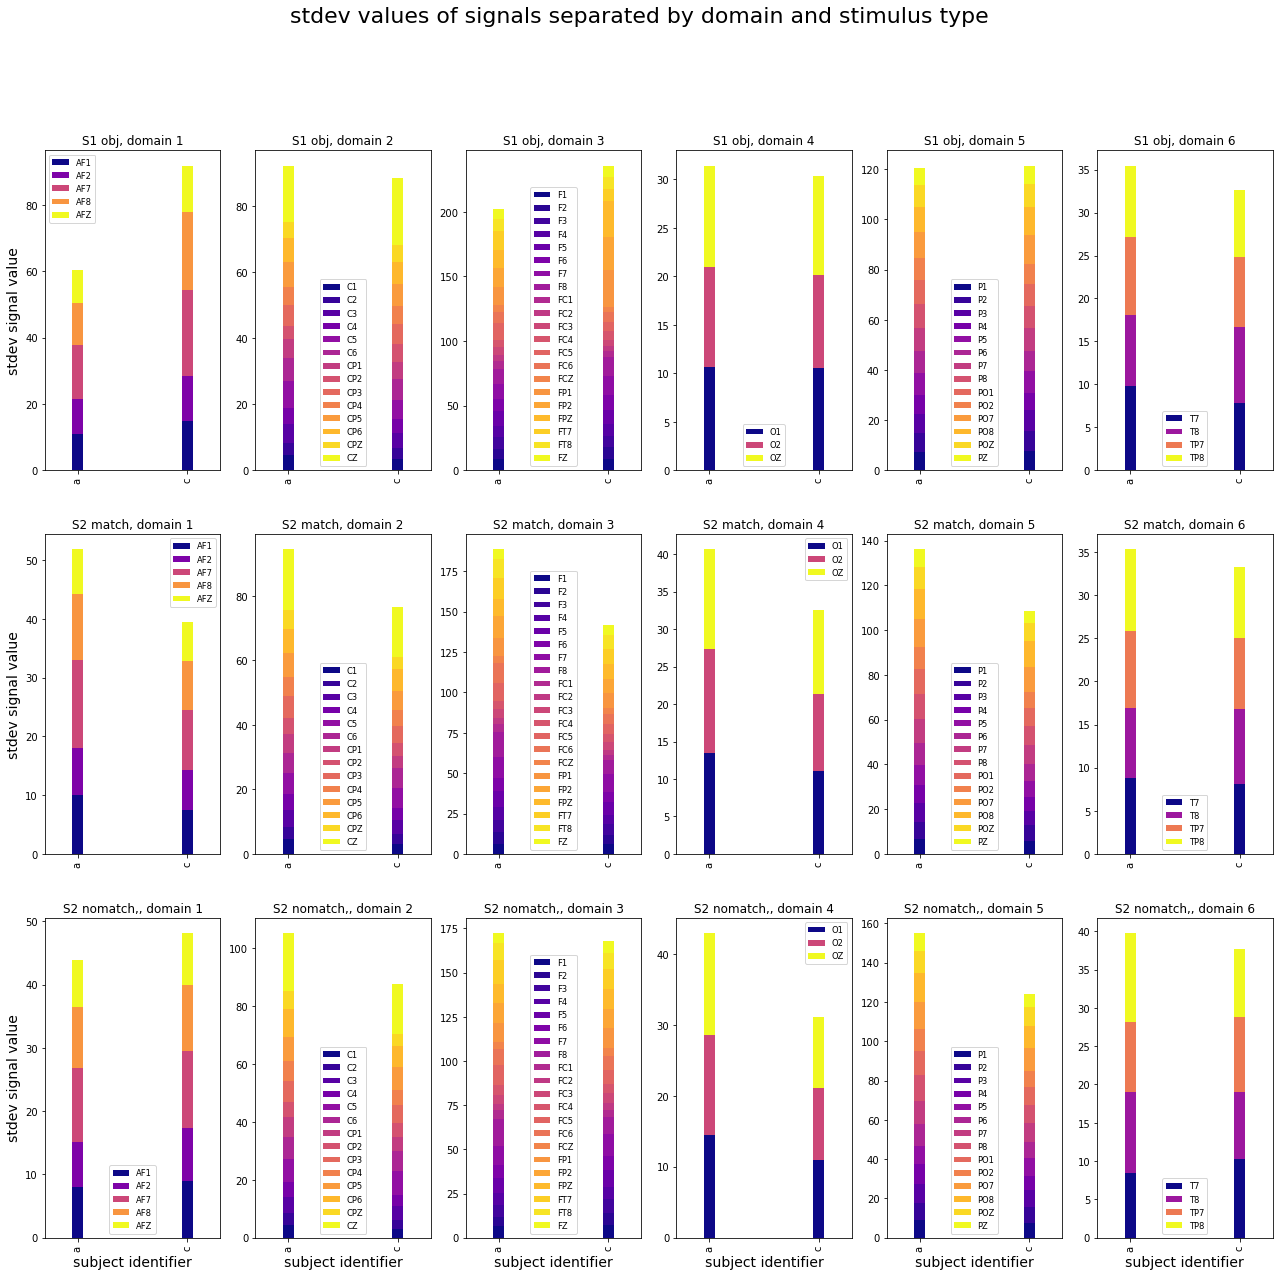

In [23]:
domains_bar_chart(df=df_train, stats = 'stdev', domains=ch_domains, stimuli=stimuli, alcoholic_id=alcoholic_id, control_id=control_id, random_seed = 81)

Based on this statistical analysis of the sample data one can conclude that:
- given the distribution and shear mean signal values, the signals collected from by domain 1 (A group) of channels show the starkest difference between the alcoholic and control groups.
- channel 'AFZ' seems to be registering the most distinct signals between the two groups.
- channel 'PZ' in domain 5 seems to be collecting the most distint signals between the two groups.
- the standard deviation of domain 4 is larger than other domains (given the small subset of channels in this domain).

Next, we visualize the pairwise correlation between the sensor positions.

### Correlation matrix of sensor positions

In [35]:
def corr_matrix(df, stimuli, alcoholic_id, control_id, random_seed):

    '''
    df: data frame containing the data for both alcoholic and control groups
    stimuli: the list of stimuli
    alcoholic_id: a list of id 'names' associated with alcoholic group
    control_id: a list of id 'names' associated with control group
    '''
    random.seed(random_seed)
    
    # pick a random id for both groups
    rand_id_a = random.choice(alcoholic_id)
    rand_id_c = random.choice(control_id)

    groups = ['a', 'c']
    (m, n) = (len(stimuli), len(groups))
    fig, ax = plt.subplots(m, n, figsize=(20, 20))

    for i in range(m):
        for j, group in enumerate(groups):
            
            if (group == 'a'):
                
                rand_df_a = df.loc[(df['name'] == rand_id_a) & (df['matching condition'] == stimuli[i])]
                trial_no_a = rand_df_a['trial number'].max()
#                 print(trial_no_a)
                rand_df_a = rand_df_a[rand_df_a['trial number'] == trial_no_a]
                
                corr_matrix_a = pd.pivot_table(rand_df_a,values='sensor value', index='time', columns='sensor position').corr()
                mask = np.triu(np.ones_like(corr_matrix_a, dtype=bool), k=0)
                sns.heatmap(corr_matrix_a, mask=mask, cmap='RdBu', square=True, cbar=True, ax=ax[i,j])
                ax[i,j].set_title(stimuli[i]+', alcoholic group')
                
            elif(group == 'c'):
                
                rand_df_c = df.loc[(df['name'] == rand_id_c) & (df['matching condition'] == stimuli[i])]
                trial_no_c = rand_df_c['trial number'].max()
#                 print(trial_no_c)
                rand_df_c = rand_df_c[rand_df_c['trial number'] == trial_no_c]
            
                corr_matrix_c = pd.pivot_table(rand_df_c,values='sensor value', index='time', columns='sensor position').corr()
                mask = np.triu(np.ones_like(corr_matrix_c, dtype=bool), k=0)
                sns.heatmap(corr_matrix_c, mask=mask, cmap='RdBu', square=True, cbar=True, ax=ax[i,j])                
                ax[i,j].set_title(stimuli[i]+', control group')
                
            ax[i,j].set_yticklabels(ax[i,j].get_yticklabels(),rotation=0)
            
    fig.suptitle("Correlation matrices of sensor positions separated by stimulus types and study groups", fontsize=18)
    fig.show()

/tmp/ipykernel_3133/10340272.py:49: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



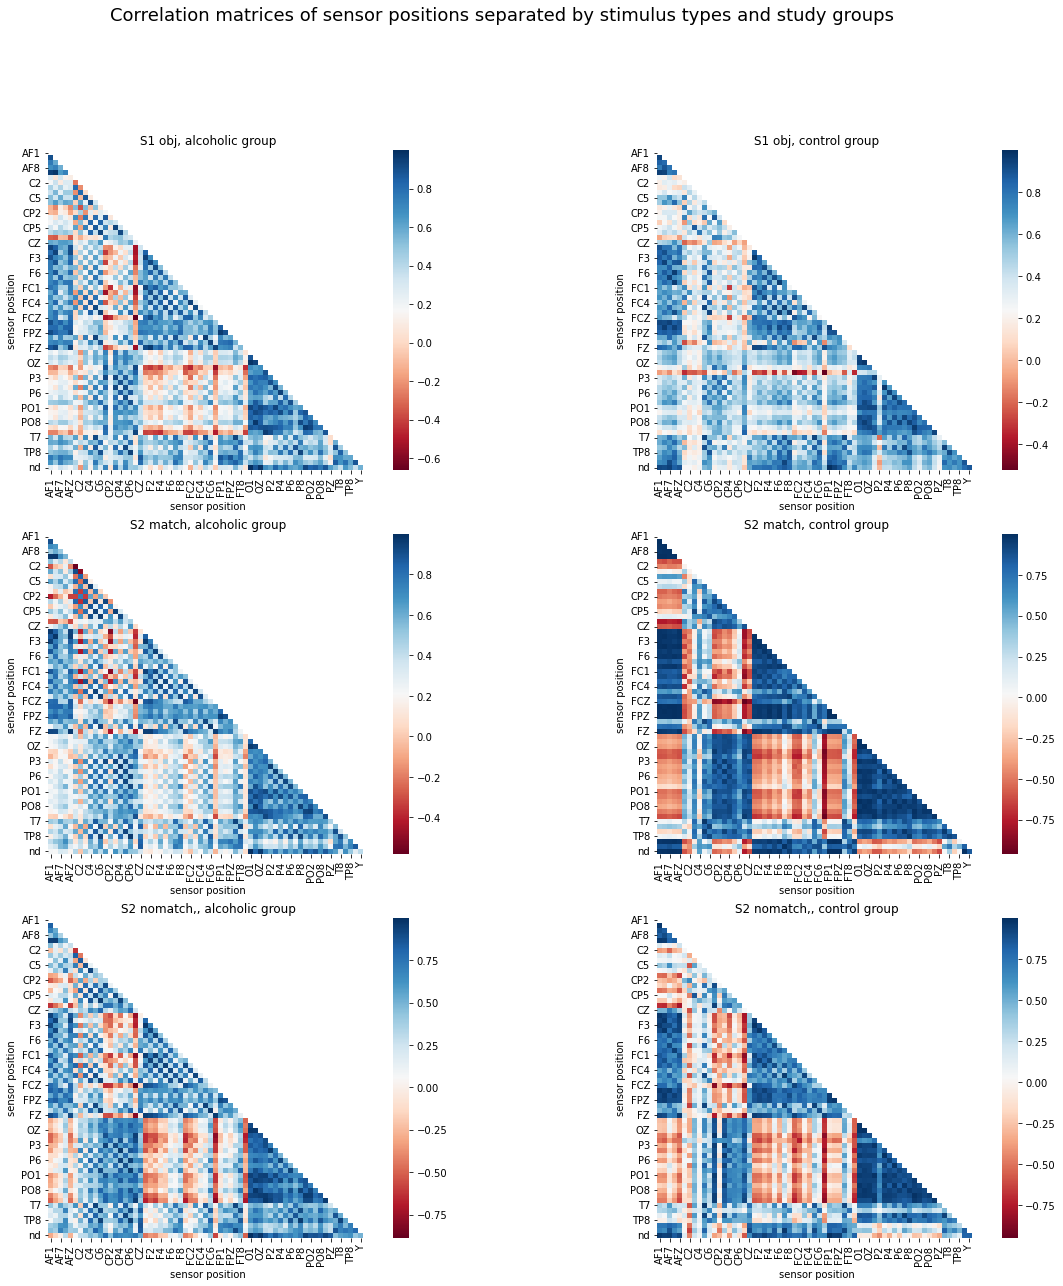

In [36]:
corr_matrix(df_train, stimuli, alcoholic_id, control_id, 45)

From the above sample correlation analysis, a few points can be inferred:
   - for the S1 obj stimulus, the control group shows a more uniform positive correlation index while the alcoholic group shows square areas with negative or weak correlation index.
   - for the S2 match stimulus, the alcoholic group has a more uniform distribution of correlation index. for the same stimulus, the control group shows neighboring areas with sharply alternating correlation index.
   - for the S2 nonmatch stimulus, the two groups have a more similar distribution of correlation index with the control group showing larger correlation indices.

## <span style="color:blue"> Neural Network Model</span>

### Dimensionality reduction and feature selection

We regroup the original train set such that each 'sensor positio' becomes a column representing the average 
signal value calculated for separate 'time' periods and "matching condition"'s. These calculated subsets are aggregated against each individual's 'name'.

Other possible options of data transformation are One-Hot Encoding the 'sensor position' column which could make it
more difficult to find an association rule due to increased dimensionality of data. Another approach is trying the 
Trigonometric Feature Engineering which keeps the cyclic pattern in the data.

In [13]:
alternating_ids = []
id_len = len(alcoholic_id)
for id_ in range(id_len):
    alternating_ids.append(alcoholic_id[id_])
    alternating_ids.append(control_id[id_])

df_train_ml = pd.DataFrame()
    
for i, id_ in enumerate(alternating_ids):
    for i, stimulus in enumerate(stimuli):
        
        df_ = df_train_orig.loc[(df_train_orig['name'] == id_) & (df_train_orig['matching condition'] == stimulus)]                
        pivot_df_ = pd.pivot_table(df_, values='sensor value', index='time',columns='sensor position', aggfunc='mean')
        sub_df_ = pivot_df_.merge(df_[['time', 'matching condition', 'subject identifier']].drop_duplicates(), on='time')
        df_train_ml = pd.concat([df_train_ml, sub_df_])

# trigonometric feature addition
period = len(np.unique(df_train_ml['time']))
df_train_ml['time_sin_transform'] = np.sin(df_train_ml['time'] * 2 * np.pi / period)
df_train_ml['time_cos_transform'] = np.cos(df_train_ml['time'] * 2 * np.pi / period)
df_train_ml.insert(0, 'time_sin_transform', df_train_ml.pop('time_sin_transform'))
df_train_ml.insert(1, 'time_cos_transform', df_train_ml.pop('time_cos_transform'))
df_train_ml = df_train_ml.drop(['time'], axis=1)

# Numerical Relabeling of target values
label_mapping = {'a': 0, 'c': 1}
df_train_ml['subject identifier'] = df_train_ml['subject identifier'].map(label_mapping)

# converting the categorical data under the "matching condition" column into numerical type.
encoder = OrdinalEncoder() # create an instance of OrdinalEncoder()
df_train_ml['matching condition'] = encoder.fit_transform(df_train_ml[['matching condition']])

In [14]:
df_train_ml

,time_sin_transform,time_cos_transform,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,...,PZ,T7,T8,TP7,TP8,X,Y,nd,matching condition,subject identifier
0,0.000000,1.000000,1.300000,0.873800,-0.640800,2.613300,1.205400,0.459900,1.021200,1.120000,...,0.190000,-0.117800,2.986700,0.158600,2.157700,1.150600,1.584900,0.922700,0.0,0
1,0.000096,1.000000,0.714200,1.166800,0.531000,1.343900,0.863600,0.459800,-0.931800,1.754900,...,0.287900,-0.362300,-1.017200,0.158600,1.327500,0.759900,1.243100,1.069200,0.0,0
2,0.000192,1.000000,0.030600,0.971400,2.386500,1.099900,0.326700,0.313400,-0.638800,2.682400,...,0.287900,-0.069100,-2.384300,0.061000,0.790300,0.906100,1.585000,0.971300,0.0,0
3,0.000288,1.000000,-0.164900,0.678400,3.851300,2.076200,0.375400,1.485100,-0.834200,2.829000,...,-0.005000,0.467900,-1.163800,0.012200,0.888000,1.736500,2.561500,1.264400,0.0,0
4,0.000383,1.000000,0.421200,0.776100,4.486100,3.492300,0.961400,0.557500,0.728400,-0.344800,...,-0.102500,0.809600,0.740600,0.549300,0.985800,2.908400,3.537900,1.752700,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.024062,0.999710,-4.343778,-3.772889,-8.285111,-2.415333,-4.498556,-1.762111,0.005556,-1.949556,...,-4.401444,-4.475889,1.143778,-5.044333,-1.199222,-14.385000,-12.775556,-5.123444,2.0,1
252,0.024158,0.999708,-4.777667,-4.098333,-8.719000,-2.903778,-4.769778,-1.816222,-0.048667,-2.004000,...,-4.509889,-5.018333,0.493000,-5.803889,-1.850444,-15.307444,-13.155333,-5.991667,2.0,1
253,0.024254,0.999706,-5.103333,-4.369667,-8.990333,-3.663222,-5.258000,-1.924778,-0.048556,-2.166667,...,-4.672667,-5.506667,-0.049667,-6.997778,-2.664222,-15.795556,-12.395778,-7.564778,2.0,1
254,0.024350,0.999704,-5.374444,-4.858000,-9.044556,-4.531333,-5.692111,-2.304556,-0.048444,-2.763556,...,-4.672667,-5.940889,-0.700778,-8.137000,-3.423556,-16.121222,-11.690444,-9.192556,2.0,1


Similarly, we define the test data frame whose data files are separately located in the TEST directory.

In [16]:
df_test_orig = pd.DataFrame()
for (root, dirs, files) in os.walk(work_dir+"data/SMNI_CMI_TEST/"):
    for name in files:
        file = pd.read_csv(root+name)
        df_test_orig = pd.concat([df_test_orig, file])

In [17]:
df_test_ml = pd.DataFrame()
    
for i, id_ in enumerate(alternating_ids):
    for i, stimulus in enumerate(stimuli):
        
        df_ = df_test_orig.loc[(df_test_orig['name'] == id_) & (df_test_orig['matching condition'] == stimulus)]                
        pivot_df_ = pd.pivot_table(df_, values='sensor value', index='time',columns='sensor position', aggfunc='mean')
        sub_df_ = pivot_df_.merge(df_[['time', 'matching condition', 'subject identifier']].drop_duplicates(), on='time')
        df_test_ml = pd.concat([df_test_ml, sub_df_])

# trigonometric feature addition
period = len(np.unique(df_test_ml['time']))
df_test_ml['time_sin_transform'] = np.sin(df_test_ml['time'] * 2 * np.pi / period)
df_test_ml['time_cos_transform'] = np.cos(df_test_ml['time'] * 2 * np.pi / period)
df_test_ml.insert(0, 'time_sin_transform', df_test_ml.pop('time_sin_transform'))
df_test_ml.insert(1, 'time_cos_transform', df_test_ml.pop('time_cos_transform'))
df_test_ml = df_test_ml.drop(['time'], axis=1)

# Numerical Relabeling of target values
label_mapping = {'a': 0, 'c': 1}
df_test_ml['subject identifier'] = df_test_ml['subject identifier'].map(label_mapping)

encoder = OrdinalEncoder() # create an instance of OrdinalEncoder()
df_test_ml['matching condition'] = encoder.fit_transform(df_test_ml[['matching condition']])

In [18]:
df_test_ml

,time_sin_transform,time_cos_transform,AF1,AF2,AF7,AF8,AFZ,C1,C2,C3,...,PZ,T7,T8,TP7,TP8,X,Y,nd,matching condition,subject identifier
0,0.000000,1.000000,1.7953,2.3681,1.0753,-0.7944,1.7354,1.6164,-0.4660,3.1504,...,-0.5932,-2.9795,-0.8605,-3.3101,-1.4985,1.5788,-1.3163,0.6083,0.0,0
1,0.000096,1.000000,1.9908,1.8311,0.8800,-2.4058,1.6867,-0.0436,-0.0754,-1.8789,...,-0.5931,-2.3937,-3.6926,-2.5776,-2.9145,1.7740,0.3927,0.9502,0.0,0
2,0.000192,1.000000,1.9908,1.3916,1.1730,-2.0641,1.7354,0.1026,0.0223,-0.5116,...,-0.5443,-1.1241,-4.9622,-1.4547,-3.2563,1.7253,2.0040,1.5849,0.0,0
3,0.000288,1.000000,1.9419,1.5381,1.9054,0.2798,1.8331,-0.2389,-0.3682,-0.9023,...,-0.3978,0.2921,-4.3274,-0.5269,-2.8657,1.7252,2.2482,2.4150,0.0,0
4,0.000383,1.000000,1.9419,2.0751,2.5889,2.9653,1.9797,1.3235,0.3153,2.5646,...,-0.2512,1.0731,-3.4485,0.0590,-1.9379,1.7252,1.3692,2.9520,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.024062,0.999710,-6.0974,-5.8725,-7.5530,-6.5684,-6.4849,-0.3275,0.6519,-0.7435,...,-1.0245,-1.8159,-0.0153,-2.6287,0.1190,-17.2750,-10.0180,-4.6499,2.0,1
252,0.024158,0.999708,-7.5136,-7.1422,-9.2623,-8.1309,-7.7545,-0.5228,0.6030,-1.1830,...,-0.8290,-2.6459,-0.8452,-3.4099,-0.5157,-18.8864,-12.2152,-4.8452,2.0,1
253,0.024254,0.999706,-8.7342,-8.4117,-10.7269,-9.6934,-8.8287,-0.8160,0.5057,-1.6225,...,-1.0732,-3.3293,-1.5290,-3.8980,-1.3947,-20.5954,-14.0705,-5.2359,2.0,1
254,0.024350,0.999704,-9.3202,-9.0466,-11.3616,-10.4747,-9.4147,-1.0600,0.4568,-2.0132,...,-1.3173,-3.9155,-1.7731,-4.0932,-1.8829,-21.9626,-14.6078,-5.7241,2.0,1


### Artificial Neural Network, with Sequential dense layers

In [19]:
x_train, y_train = df_train_ml.iloc[:, :-1].values, df_train_ml.iloc[:, -1].values
x_test, y_test = df_test_ml.iloc[:, :-1].values, df_test_ml.iloc[:, -1].values
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [26]:
# Definitions & Model configuration
classes = np.unique(df_train_ml.iloc[:,-1].values)
n_classes = len(classes)
features = list(df_train_ml.columns.values)
features.pop() # drop the 'target' from the list
n_features = len(features)
no_epochs = 30
verbosity = 0
rand_state = 1

# Create the model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(n_features,)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 67)               135       
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                4352      
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,672
Trainable params: 5,537
Non-trainable params: 135
__________________________________________________

In [27]:
# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(.01),
              metrics=['accuracy'])

# Fit data to the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test,y_test),
                    epochs=no_epochs,
                    verbose=verbosity
)

# Generate generalization metrics
print("Sequential model:\n")
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

Sequential model:

Test loss: 1.070679783821106 / Test accuracy: 0.5


/tmp/ipykernel_3133/1508769082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_3133/1508769082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

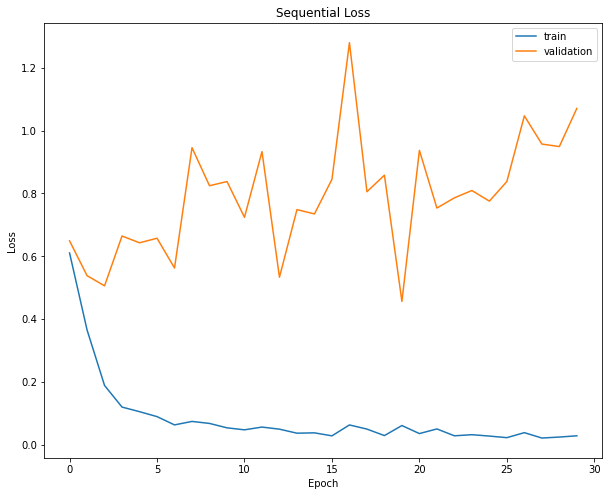

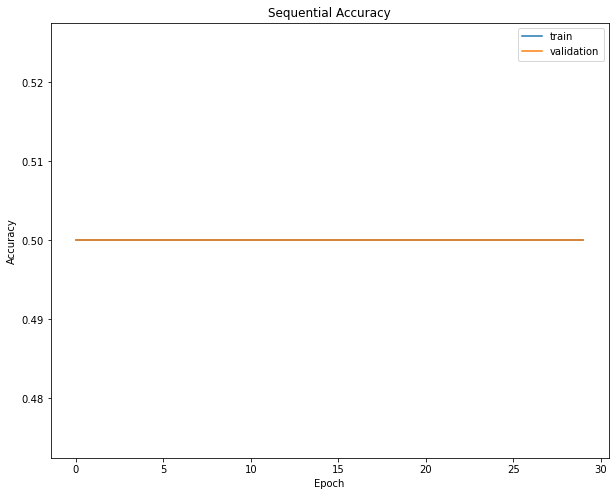

In [28]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Sequential Loss',figsize=(10,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Sequential Accuracy',figsize=(10,8)).set(xlabel='Epoch',ylabel='Accuracy')